# Bank Analysis with A/B Testing on Marketing Campaign
By: Johnathan Bailey

# Table of Contents
1. [Business Understanding](#1)
2. [Model Performances](#2)
3. [Data Understanding](#3)
4. [Data Understanding](#4)
5. [Data Visualization](#5)
6. [Data Cleaning](#6)
7. [Data Processing](#7)
8. [Create Test and Train Data](#8)
9. [Decision Tree Model](#9)
10. [Logistic Regression Model](#10)
11. [Feature importance](#last-bullet)


## Business Understanding <a name="1"></a>

You are a Data Scientist with the marketing team at a banking institution. The Marketing Manager has been running phone based marketing campaigns to market the new product which is a bank term deposit. The manager has historical data from marketing campaigns in the past for a similar product. Historical data is available in full.csv dataset. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

<a id="2"></a>
## Model Performances

Below are the performance metrics for both Decision Tree and Logistic Regression models. The first set is with all predicitve variables, and the second is with only a subset of the highest significant predictive variables.

Decision Tree w/ all predictive variables:
```
accuracy_train: 0.9964626268840356
accuracy_test: 0.6515478761699064
precision: 0.6504646175839885
recall: 0.6551475881929446
f1: 0.6527977044476327
mse: 0.3484521238300936
variance: 0.2499870420733512
```
Logistic Regression w/ all predictive variables:
```
accuracy_train: 0.7474623192863734
accuracy_test: 0.7293016558675306
precision: 0.7913998170173834
recall: 0.6227501799856011
f1: 0.6970185334407736
mse: 0.2706983441324694
variance: 0.23864678298738262
```

Decision Tree w/ subset of predictive variables:
```
accuracy_train: 0.7714549369424792
accuracy_test: 0.7275017998560115
precision: 0.8191919191919191
recall: 0.583873290136789
f1: 0.6817990752416981
mse: 0.27249820014398846
variance: 0.2293708511958352
```

Logistic Regression w/ subset of predictive variables:
```
accuracy_train: 0.7265456782528453
accuracy_test: 0.7170626349892009
precision: 0.7299771167048055
recall: 0.6889848812095032
f1: 0.7088888888888889
mse: 0.28293736501079914
variance: 0.24921163974268667
```
Looking at all four models, it appears that limiting the features proves to be the best perfomance. Out of the two models, it is very close but Logistic Regression wins with a slightly higher f1. The key determiner of model performance is the recall score as we are trying to accurately determine the number of true positives. The better the recall score, the better we are at determining true positives over false negatives.

In [4]:
import numpy as np
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics

## Data Understanding

In [5]:

data = pd.read_csv("full.csv")
data = data.drop("duration",axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
print("shape:",data.shape)
print("========================================")
print("info:",data.info())
print("========================================")
print(data.describe())
print("========================================")
print("missing values:",data.isnull().sum())

shape: (41188, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m   

Some things to note:
1. Age looks to have some outliers. A minimum of 17 is interesting in that a bank would target someone who is not a legal adult to take part in a Deposit campaign. A max age of 98 is also interesting, in that there is a chance that clients data is unrealiable due to age as well. We will need to normalize these numerical columns going into our model creation.
2. Number of employed is very interesting in that it isnt interesting at all. Looking at the min, 25, 50, 75, and max, it shows that the spread is fairly plateau of the number of employees. i.e. it doesnt waver all too much. When we go to select features to be used to help predict column y, the likelyhood of this column haveing any correlation in the outcome is rather small. Visualization and a correlation matrix should back this theory.
3. As with number of employees, pdays also looks to not be significant data. 75% of the data is exactly the same, 999 as you can see above.
4. alot of the numerical data tends to not waiver in standard deviation, or distance from the mean. This gives me the hint that the categorical data will be huge in finding y with a machine learning model.

In [43]:
columns = data.columns
columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [8]:
numeric_data = data.select_dtypes(exclude='object')
categorical_data = data.select_dtypes(exclude=['int64','float64'])
categorical_data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no


### Data Visualization

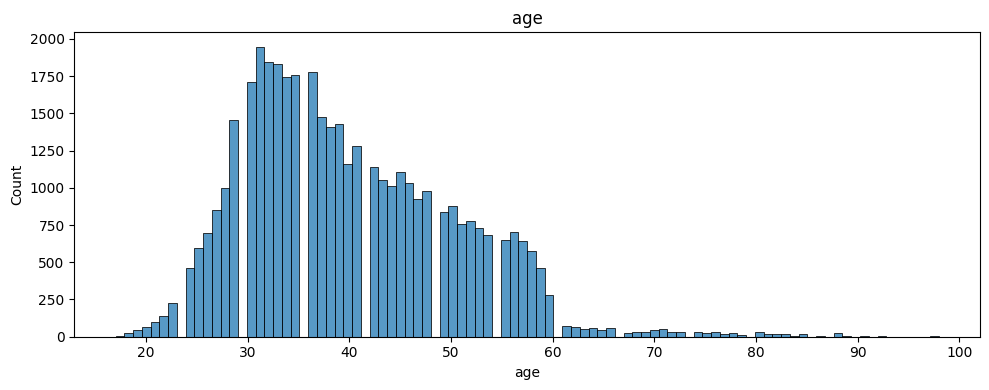

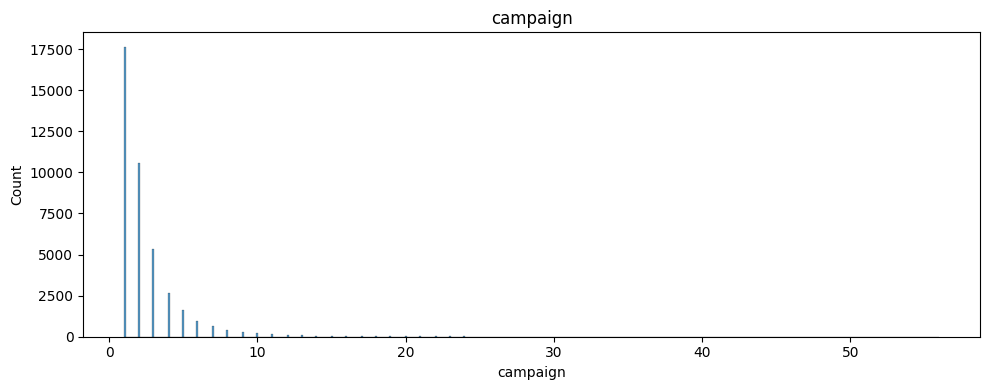

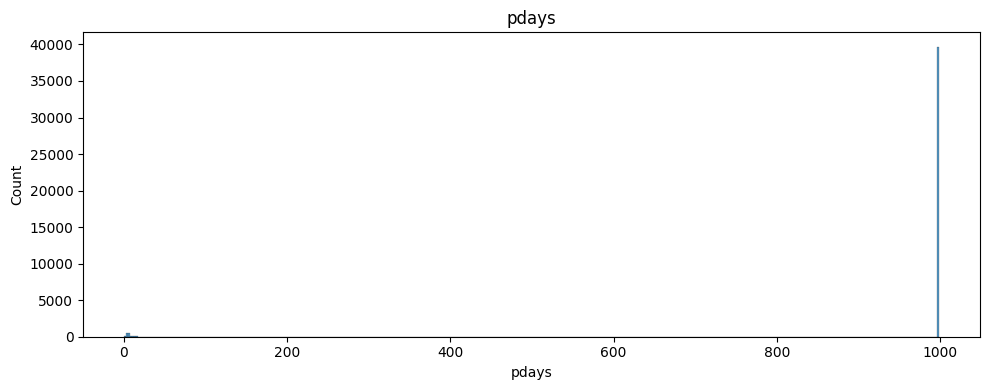

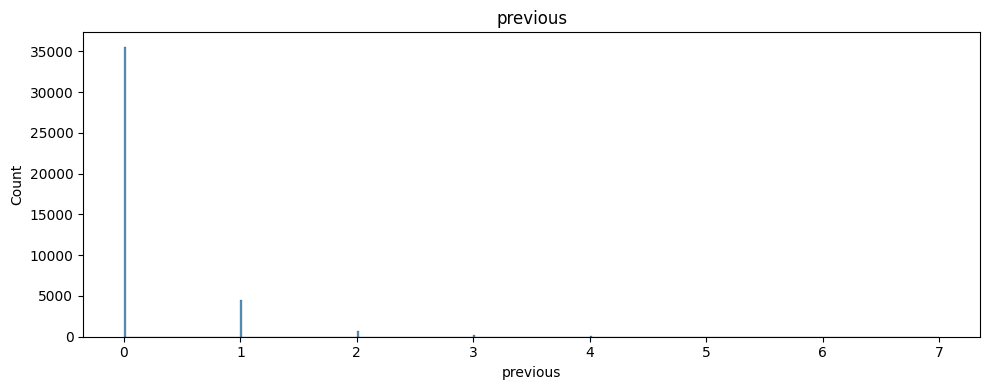

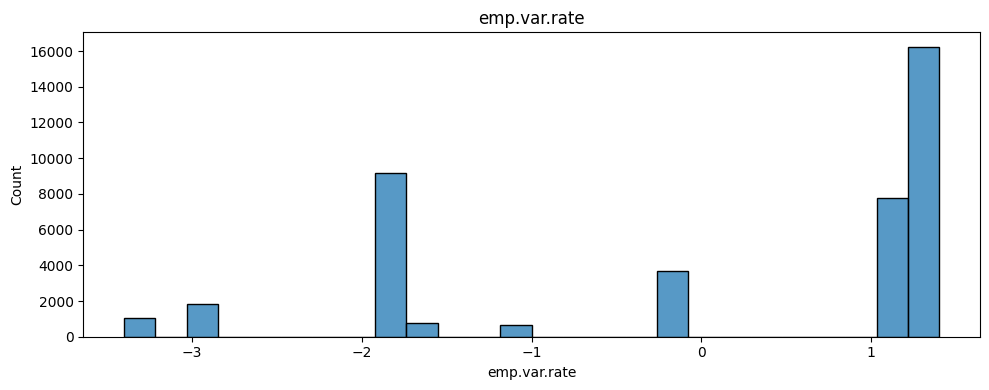

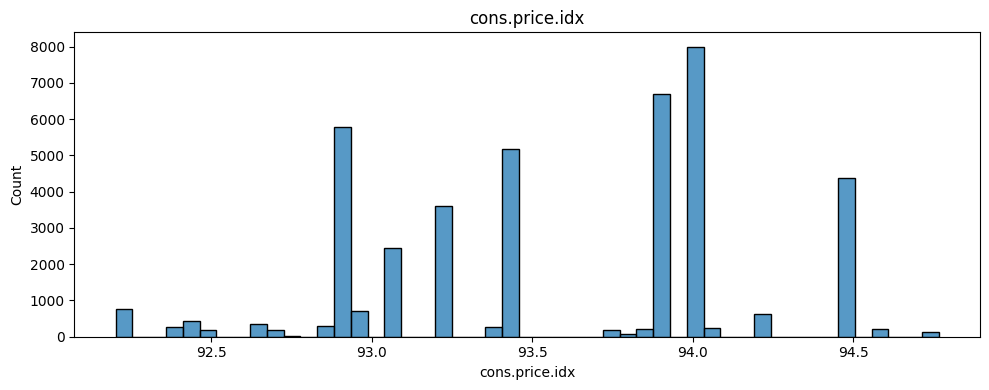

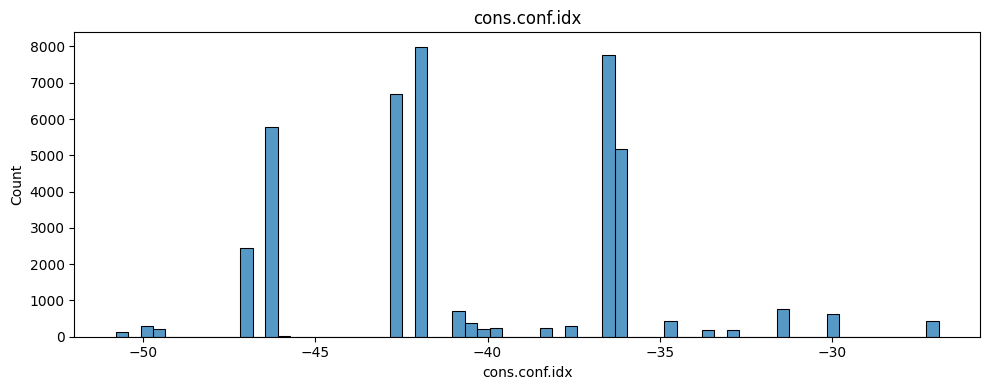

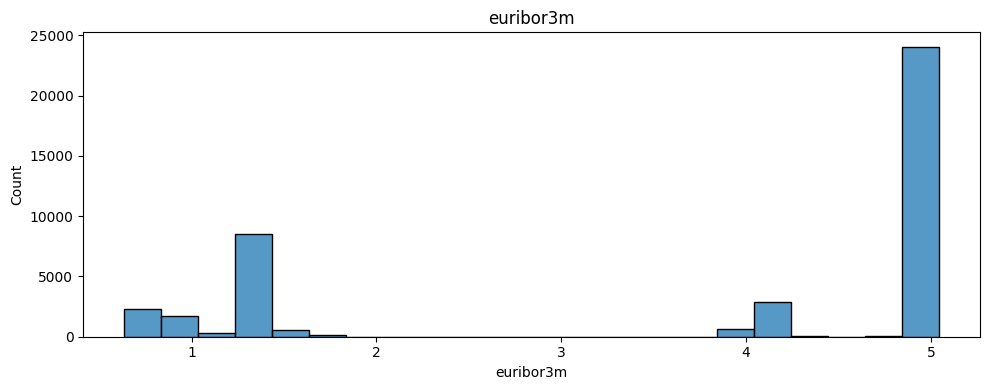

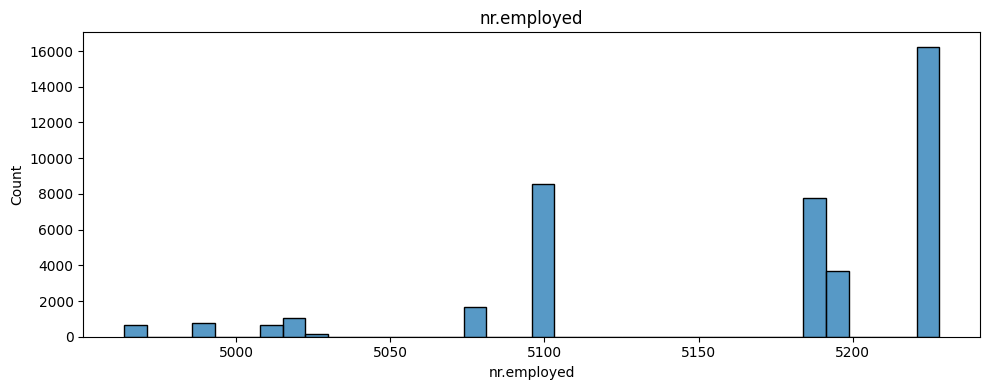

In [9]:
for col in numeric_data.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=data, x=col)
    plt.title(col)
    plt.tight_layout()

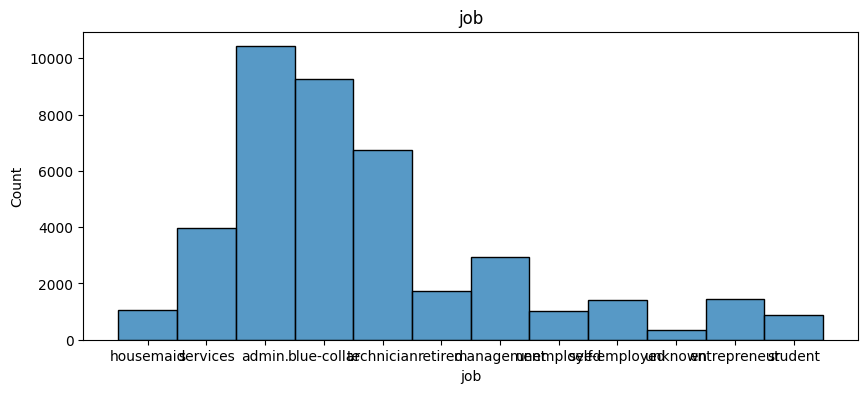

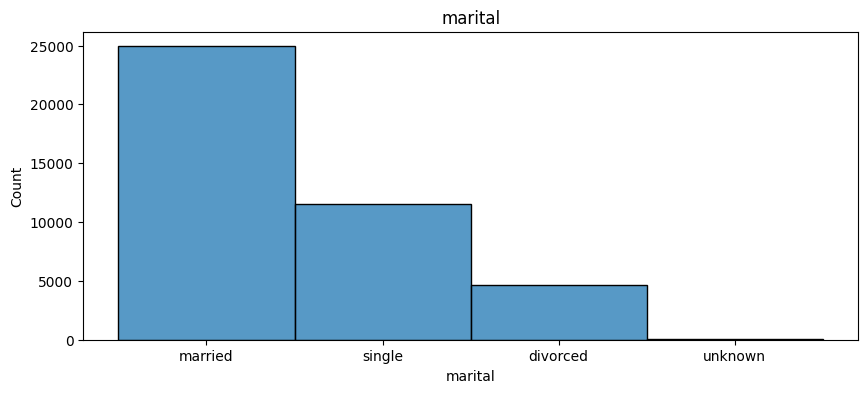

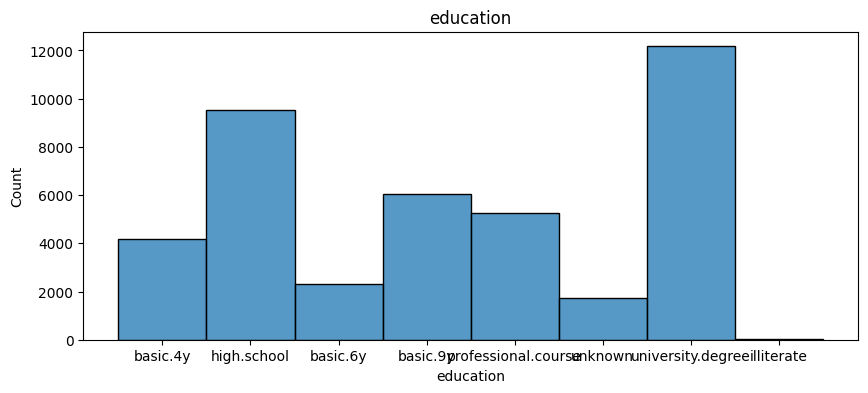

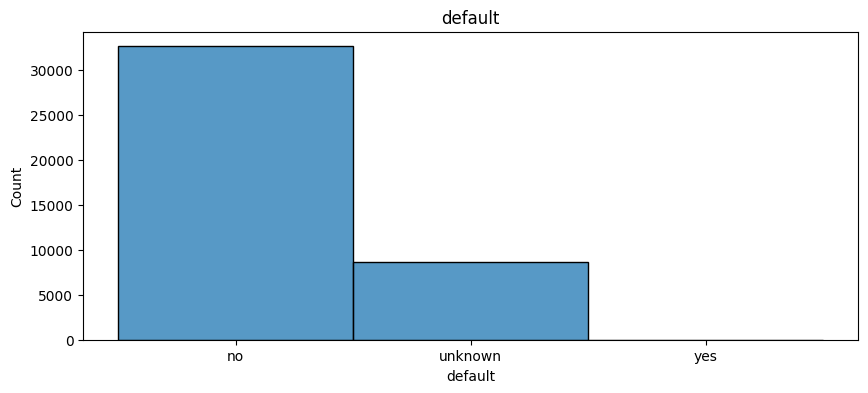

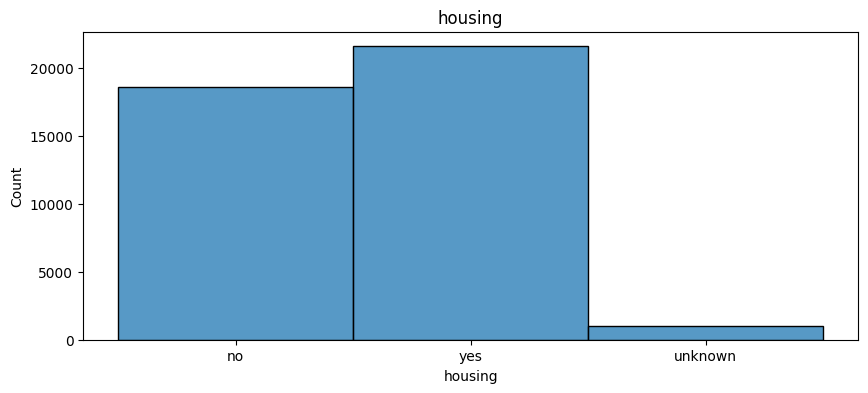

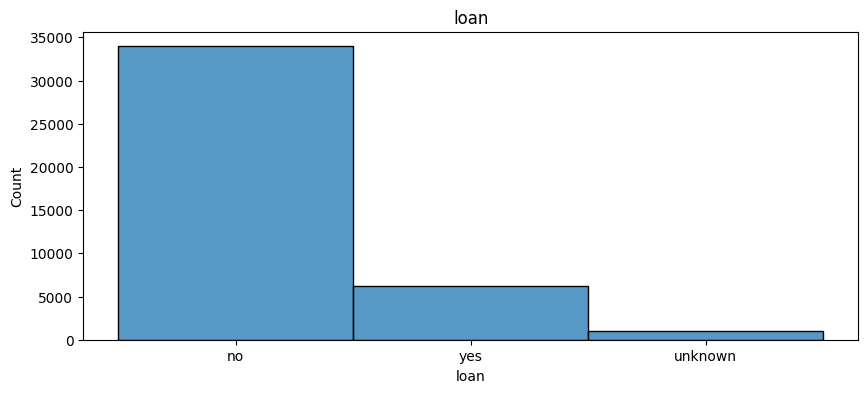

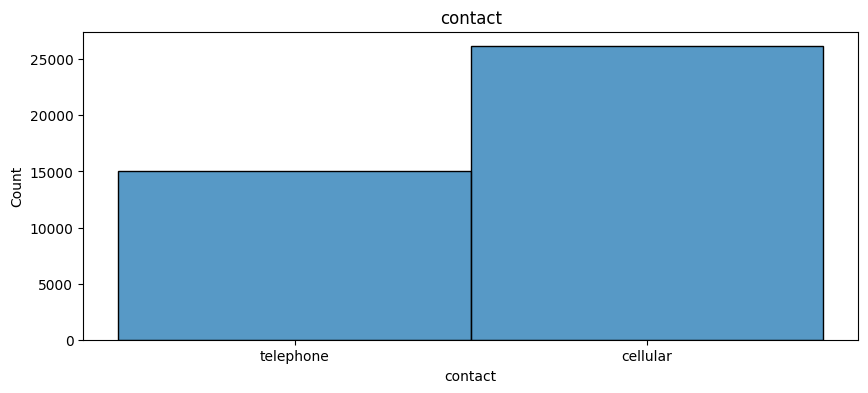

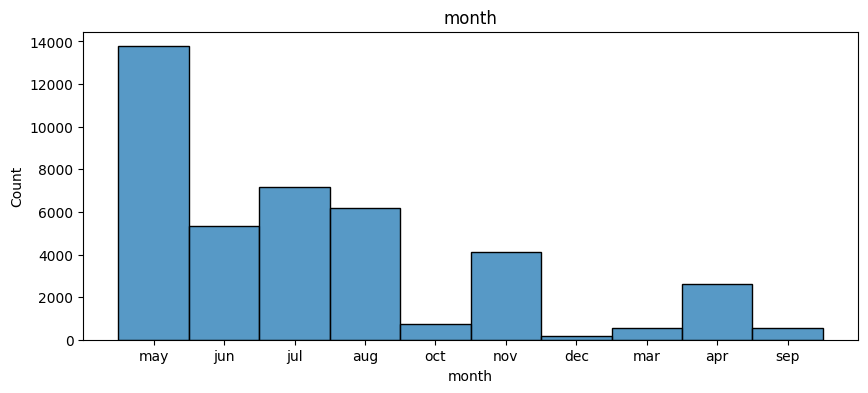

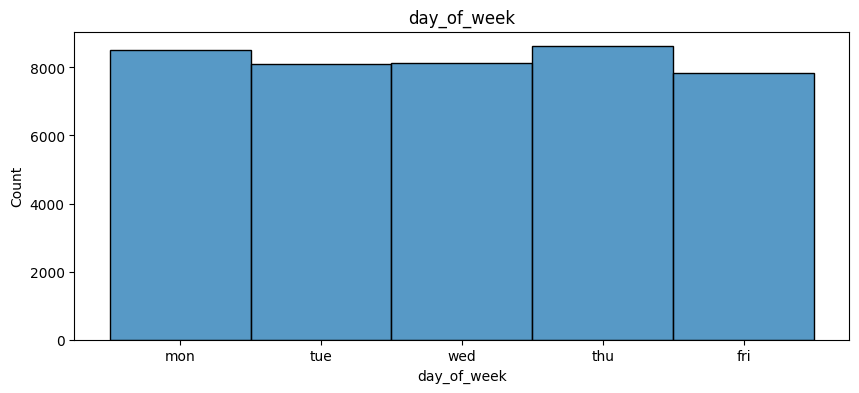

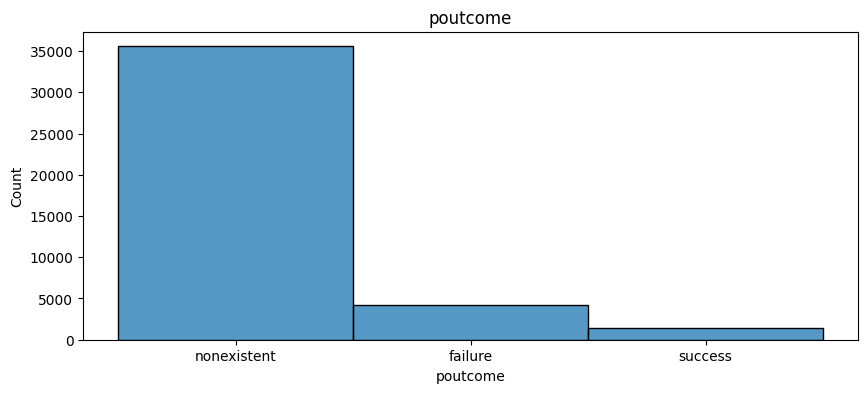

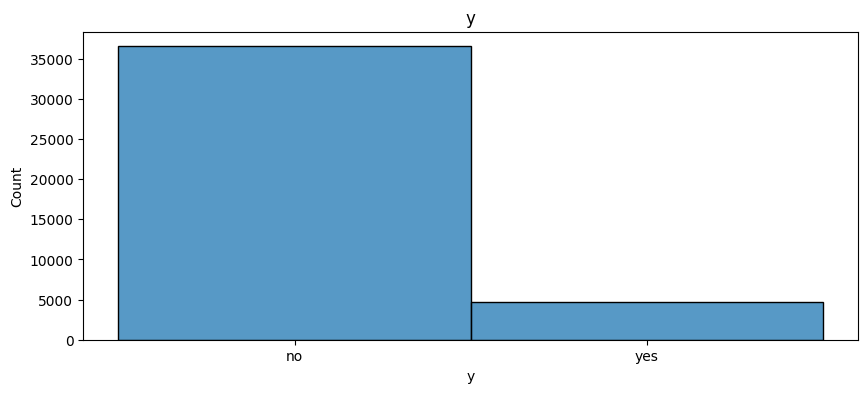

In [10]:
for col in categorical_data.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(data=data, x=col)
    plt.title(col)

Some things to note:
1) it appears that there are columns with unknown variables like 'job', 'education', etc. We need to take a look on possibly filling those unknown variables based on any correlation with the other columns such as job and education, job and age, etc.

### Data Cleaning

In [12]:
data['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

It appears that job has unknown values. We can clean this up by cross referencing with education and inferring the job based on education.

In [13]:
pd.crosstab(data['job'], data['education'])

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
job,,,,,,,,
admin.,77,151,499,3329,1,363,5753,249
blue-collar,2318,1426,3623,878,8,453,94,454
entrepreneur,137,71,210,234,2,135,610,57
housemaid,474,77,94,174,1,59,139,42
management,100,85,166,298,0,89,2063,123
retired,597,75,145,276,3,241,285,98
self-employed,93,25,220,118,3,168,765,29
services,132,226,388,2682,0,218,173,150
student,26,13,99,357,0,43,170,167


From the crosstab we can see that people who are in management at least have a university degree, so we can replace education with university degree. This can also be done with similar jobs like service and highschoo, housemaid and basic 4 years. We can also make the decision that if education is basic4y, basic6y and basic9y then the job is blue collar. If education is professional course then the job is technision. 

In [14]:
data.loc[(data['education']=='unknown') & (data['job']=='management'), 'education'] = 'university.degree'
data.loc[(data['education']=='unknown') & (data['job']=='services'), 'education'] = 'high.school'
data.loc[(data['education']=='unknown') & (data['job']=='housemaid'), 'education'] = 'basic.4y'
data.loc[(data['job'] == 'unknown') & (data['education']=='basic.4y'), 'job'] = 'blue-collar'
data.loc[(data['job'] == 'unknown') & (data['education']=='basic.6y'), 'job'] = 'blue-collar'
data.loc[(data['job'] == 'unknown') & (data['education']=='basic.9y'), 'job'] = 'blue-collar'
data.loc[(data['job']=='unknown') & (data['education']=='professional.course'), 'job'] = 'technician'

In [15]:
data['job'].value_counts()

job
admin.           10422
blue-collar       9359
technician        6755
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            213
Name: count, dtype: int64

In [16]:
pd.crosstab(data['job'], data['age'])

age,17,18,19,20,21,22,23,24,25,26,...,85,86,87,88,89,91,92,94,95,98
job,,,,,,,,,,,,,,,,,,,,,
admin.,0,0,0,1,12,13,49,82,158,206,...,0,0,0,0,0,0,0,0,0,0
blue-collar,0,0,0,7,15,31,58,82,134,152,...,0,0,0,0,0,0,0,0,0,0
entrepreneur,0,0,0,4,0,0,3,5,8,14,...,0,0,0,0,0,0,0,0,0,0
housemaid,0,0,0,0,1,1,1,2,6,9,...,5,0,0,0,0,0,0,0,0,0
management,0,0,0,0,1,1,9,16,11,21,...,0,0,0,0,0,0,0,0,0,0
retired,0,0,0,0,0,0,1,0,0,1,...,10,8,1,22,2,2,4,1,1,2
self-employed,0,0,0,0,2,2,2,6,28,23,...,0,0,0,0,0,0,0,0,0,0
services,0,0,0,3,12,23,26,94,88,74,...,0,0,0,0,0,0,0,0,0,0
student,5,28,42,46,54,49,53,101,76,77,...,0,0,0,0,0,0,0,0,0,0


We can determine from this that if the age is 60 or older, it is a fair assessment that their occupation is 'retired

In [17]:
data.loc[(data['job']=='unknown') & (data['age'] >= 60), 'job'] = 'retired'

In [18]:
data['job'].value_counts()

job
admin.           10422
blue-collar       9359
technician        6755
services          3969
management        2924
retired           1741
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            192
Name: count, dtype: int64

In [19]:
df_clean = data.copy()

In [20]:
df_clean.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Data Processing

To handle the columns we will do the following:
1. Normalize the numerical columns using sklearn's scaler package
2. One Hot Encode the categorical columns so that our model will be able to handle the data

In [21]:
from sklearn.preprocessing import StandardScaler

data_copy = df_clean.copy()

scaler = StandardScaler()

numeric_data_cols = data_copy.select_dtypes(exclude="object")

data_copy[numeric_data_cols.columns] = scaler.fit_transform(data_copy[numeric_data_cols.columns])
data_copy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.533034,housemaid,married,basic.4y,no,no,no,telephone,may,mon,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.71246,0.33168,no
1,1.628993,services,married,high.school,unknown,no,no,telephone,may,mon,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.71246,0.33168,no
2,-0.290186,services,married,high.school,no,yes,no,telephone,may,mon,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.71246,0.33168,no
3,-0.002309,admin.,married,basic.6y,no,no,no,telephone,may,mon,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.71246,0.33168,no
4,1.533034,services,married,high.school,no,no,yes,telephone,may,mon,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.71246,0.33168,no


In [25]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
cat_cols = categorical_data.columns
cat_cols = cat_cols.drop('y')

# Encode Categorical Data
data_copy_encoded = pd.DataFrame(encoder.fit_transform(data_copy[cat_cols]))
data_copy_encoded.columns = encoder.get_feature_names_out(cat_cols)

# Replace Categotical Data with Encoded Data
data_copy = data_copy.drop(cat_cols ,axis=1)
data_copy = pd.concat([data_copy_encoded, data_copy], axis=1)

# Encode target value
data_copy['y'] = data_copy['y'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', data_copy.shape)
data_copy.head()

Shape of dataframe: (41188, 63)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0


### Create Test and Train Data

In [26]:
features = data_copy.drop('y', axis=1)
target = data_copy['y']

The number of negative 'y' outcomes thoroughly outweigh the number of positive 'y' outcomes. It will be crucial that the train set contains a healthly amount of both so that the model 'sees' what a positive outcome is. This will help the model accurately predict positive outcomes.

In [40]:
#shuffle the data
shuffled_data = data_copy.sample(n=len(data_copy), random_state=42)
shuffled_data = data_copy.reset_index(drop=True)

df_test_all = shuffled_data.sample(frac=0.3, random_state=42)

df_train_all = shuffled_data.drop(df_test_all.index)

#split the train into positive and negative 'y' outcomes
rows_pos = df_train_all['y'] == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge so that there is an equal amount of positive and negative results
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of the training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)


# split the test into positive and negative 'y' outcomes
rows_pos = df_test_all['y']== 1
df_test_pos = df_test_all.loc[rows_pos]
df_test_neg = df_test_all.loc[~rows_pos]

# merge so that there is an equal amount of positive and negative results
df_test_all = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos), random_state = 42)],axis = 0)

# shuffle the order of testing samples 
df_test_all = df_test_all.sample(n = len(df_test_all), random_state = 42).reset_index(drop = True)


Now we need to create the matrices for our models to run through

In [41]:
x_train = df_train.drop('y', axis=1).values
x_train_all = df_train_all.drop('y', axis=1).values
x_test = df_test_all.drop('y', axis=1).values

y_train = df_train['y'].values
y_test = df_test_all['y'].values

In [42]:
# helper function to print out the evaluations of our models

def evaluate(model, x_train, x_test, y_train, y_test):
    ml_model = model
    ml_model.fit(x_train, y_train)
    predictions_train = ml_model.predict(x_train)
    predictions = ml_model.predict(x_test)
    
    mse = mean_squared_error(y_test, predictions)
    
    variance = np.var(predictions)
    
    accuracy_train = metrics.accuracy_score(y_train, predictions_train)
    accuracy_test = metrics.accuracy_score(y_test, predictions)
    
    precision = metrics.precision_score(y_test, predictions)
    
    recall = metrics.recall_score(y_test, predictions )
    
    f1 = metrics.f1_score(y_test, predictions)
    
    return({'accuracy_train' : accuracy_train,
            'accuracy_test' : accuracy_test,
           'precision' : precision,
           'recall' : recall,
           'f1': f1,
           'mse' : mse,
           'variance' : variance})

### Decision Tree Model

In [30]:
# Decision Tree fit, predict, and evaluation
dtree = tree.DecisionTreeClassifier(random_state=0)
dtree.fit(x_train, y_train)
dtree_evaluation = evaluate(dtree, x_train, x_test, y_train, y_test)

print('accuracy_train:', dtree_evaluation['accuracy_train'])
print('accuracy_test:', dtree_evaluation['accuracy_test'])
print('precision:', dtree_evaluation['precision'])
print('recall:', dtree_evaluation['recall'])
print('f1:', dtree_evaluation['f1'])
print('mse:', dtree_evaluation['mse'])
print('variance:', dtree_evaluation['variance'])

accuracy_train: 0.9966164257151645
accuracy_test: 0.652267818574514
precision: 0.6524873828406633
recall: 0.6515478761699064
f1: 0.6520172910662824
mse: 0.34773218142548595
variance: 0.249999481682934


### Logistic Regression Model

In [54]:
# logistic regression fit, predict, and evaluation

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(x_train, y_train)
log_reg_evaluation = evaluate(log_reg, x_train, x_test, y_train, y_test)

print('accuracy_train:', log_reg_evaluation['accuracy_train'])
print('accuracy_test:', log_reg_evaluation['accuracy_test'])
print('precision:', log_reg_evaluation['precision'])
print('recall:', log_reg_evaluation['recall'])
print('f1:', log_reg_evaluation['f1'])
print('mse:', log_reg_evaluation['mse'])
print('variance:', log_reg_evaluation['variance'])

accuracy_train: 0.7474623192863734
accuracy_test: 0.7289416846652268
precision: 0.7906764168190128
recall: 0.6227501799856011
f1: 0.6967378171566653
mse: 0.2710583153347732
variance: 0.23872336433387703


### Feature Importance <a class="anchor" id="last-bullet"></a>

In [47]:
log_reg.intercept_

array([-0.79149159])

In [33]:
log_reg.coef_

array([[-1.08942486e-02, -1.66121236e-01,  6.98939120e-02,
        -5.07219893e-01, -2.14430382e-02,  3.67569371e-01,
         1.82214447e-02, -1.04418746e-01,  1.34601063e-01,
         2.04592845e-02,  9.52901852e-02, -1.97991991e-02,
         4.63310594e-02,  1.13866354e-01,  2.95629095e-02,
        -3.13621423e-01,  2.88968442e-04, -4.93328952e-02,
        -7.98690802e-02, -9.39748277e-02,  6.44186305e-01,
        -1.97161842e-01, -1.33785039e-02, -3.34619225e-01,
        -2.83503588e-03, -1.21026064e-01,  0.00000000e+00,
         2.04238053e-03, -3.71214072e-02, -8.87820733e-02,
        -1.12079585e-01, -3.71214072e-02,  2.53398919e-02,
         2.28931022e-01, -3.52792122e-01, -3.39167698e-01,
         4.53176618e-01,  6.45983019e-01, -1.19412645e-01,
        -6.62065417e-01,  1.19427485e+00, -7.64880764e-01,
        -6.73585904e-01,  3.54247623e-01, -2.12430785e-01,
        -8.63921450e-02, -2.31165703e-01,  5.65647342e-02,
        -2.06120752e-02,  1.57744089e-01, -2.09654760e-0

In [34]:
corr_matrix = data_copy.corr()
corr_y = corr_matrix['y'].sort_values(ascending=False)

<Axes: >

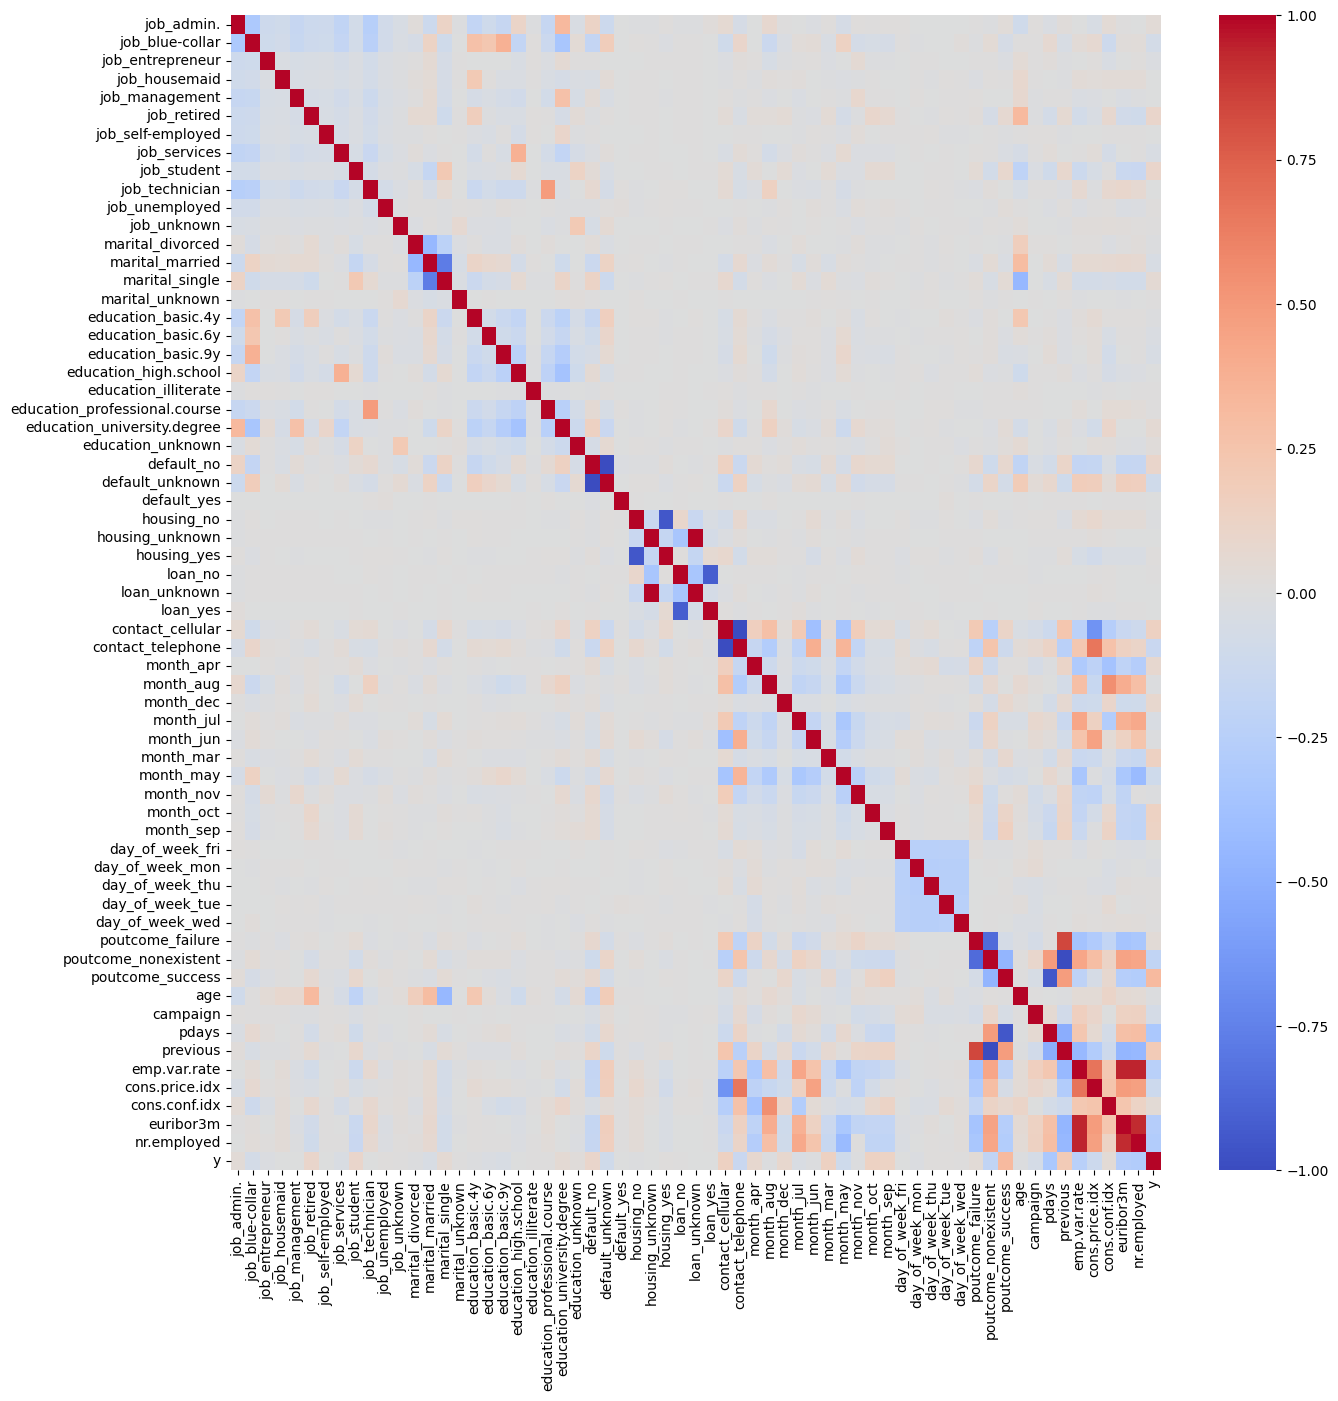

In [35]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data_copy.corr(method='spearman'), annot=False, cmap='coolwarm')

In [36]:
print("Strong positive correlation:\n")
print(corr_y[corr_y > 0.1])
print("\nStrong negative correlation:\n")
print(corr_y[corr_y < -0.1])

Strong positive correlation:

y                   1.000000
poutcome_success    0.316269
previous            0.230181
contact_cellular    0.144773
month_mar           0.144014
month_oct           0.137366
month_sep           0.126067
Name: y, dtype: float64

Strong negative correlation:

month_may              -0.108271
cons.price.idx         -0.136211
contact_telephone      -0.144773
poutcome_nonexistent   -0.193507
emp.var.rate           -0.298334
euribor3m              -0.307771
pdays                  -0.324914
nr.employed            -0.354678
Name: y, dtype: float64


We are going to re fit the model but this time with features that only have a strong corralation. From our correlation matrix, that appears to be 'poutcome_success', 'pdays_bet_5_15', 'previous', 'nr.employed', 'pdays_missing', 'euribor3m', 'emp.var.rate'

In [37]:
features = ['poutcome_success', 'poutcome_nonexistent', 'previous', 'nr.employed', 'pdays', 'euribor3m', 'emp.var.rate']

x_train = df_train[features].values
x_train_all = df_train_all[features].values
x_test = df_test_all[features].values

y_train = df_train['y'].values
y_test = df_test_all['y'].values

In [38]:
dtree = tree.DecisionTreeClassifier(random_state=0)
dtree.fit(x_train, y_train)
dtree_evaluation = evaluate(dtree, x_train, x_test, y_train, y_test)

print('accuracy_train:', dtree_evaluation['accuracy_train'])
print('accuracy_test:', dtree_evaluation['accuracy_test'])
print('precision:', dtree_evaluation['precision'])
print('recall:', dtree_evaluation['recall'])
print('f1:', dtree_evaluation['f1'])
print('mse:', dtree_evaluation['mse'])
print('variance:', dtree_evaluation['variance'])

accuracy_train: 0.7722239310981237
accuracy_test: 0.7289416846652268
precision: 0.8212121212121212
recall: 0.5853131749460043
f1: 0.6834804539722572
mse: 0.2710583153347732
variance: 0.2293708511958352


In [39]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(x_train, y_train)
log_reg_evaluation = evaluate(log_reg, x_train, x_test, y_train, y_test)

print('accuracy_train:', log_reg_evaluation['accuracy_train'])
print('accuracy_test:', log_reg_evaluation['accuracy_test'])
print('precision:', log_reg_evaluation['precision'])
print('recall:', log_reg_evaluation['recall'])
print('f1:', log_reg_evaluation['f1'])
print('mse:', log_reg_evaluation['mse'])
print('variance:', log_reg_evaluation['variance'])

accuracy_train: 0.7299292525376807
accuracy_test: 0.7224622030237581
precision: 0.7475961538461539
recall: 0.67170626349892
f1: 0.7076222980659841
mse: 0.2775377969762419
variance: 0.24742383460295098


With only using features with high correlation we get better precision, recall, and f1 scores across both models.